In [39]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
from torchvision import datasets, transforms
import numpy as np
import plotter as pltr
from copy import copy
import random
from collections import OrderedDict
pltr.set_backend(pltr.MatplotlibBackend)

In [4]:
xform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [10]:
trainset = datasets.FashionMNIST('/data/pytorch/fashion_mnist/', download=True, train=True, transform=xform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('/data/pytorch/fashion_mnist/', download=True, train=False, transform=xform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [14]:
# Utility function to plot images
white = pltr.Color(red=255, green=255, blue=255)
big_white_font = pltr.Font(color=white, size=14)
    
def rehydrate(img):
    img = copy(img.numpy())
    img = img.squeeze()  # Get rid of the single channel dim
    img = (img * 0.5) + 0.5  # Denormalize
    img = 255 * img  # Re-scale to 0-255
    return img
    
def show_imgs(imgs, titles):
    frame = pltr.Frame()
    frame.layout(1, len(imgs))  # Show all the images in a single row
    for img, title in zip(imgs, titles):
        chart = frame.create_chart()
        chart.title = title
        chart.title_font = big_white_font
        chart.show_axes = False
        imgplot = pltr.GrayscaleImage(img)
        chart.add(imgplot)
    frame.show()
    
def show_classification(img, label, probs):
    frame = pltr.Frame()
    frame.layout(1, 2)
    
    # Image chart
    chart = frame.create_chart()
    chart.title = label
    chart.title_font = big_white_font
    chart.show_axes = False
    imgplot = pltr.GrayscaleImage(img)
    chart.add(imgplot)
    
    # Probs plot
    chart = frame.create_chart()
    chart.title = 'Class Probabilities'
    chart.title_font = big_white_font
    chart.x_axis.limits = (0, 1)
    chart.x_axis.font = pltr.Font(color=white)
    chart.y_axis.font = pltr.Font(color=white)
    cats = [str(v) for v in range(len(probs))]
    probsplot = pltr.HorizontalBar(categories=cats, values=probs)
    chart.add(probsplot)
    
    frame.show()

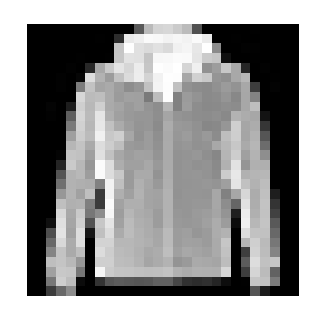

In [18]:
images, labels = next(iter(trainloader))
img = rehydrate(images[0])
lbl = labels[0].item()
show_imgs([img], [lbl])

In [51]:
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(784, 128)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(128, 64)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(64, 32)),
    ('relu3', nn.ReLU()),
    ('logits', nn.Linear(32, 10))
]))
model.fc1.bias.data.fill_(0.)
model.fc2.bias.data.fill_(0.)
model.fc3.bias.data.fill_(0.)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [55]:
epochs = 50
for epoch in range(epochs):
    tot_batches = 0
    tot_loss = 0
    for images, labels in trainloader:
        tot_batches += 1
        batch_size = images.size()[0]
        images.resize_(batch_size, 784)
        optimizer.zero_grad()
        output = model.forward(images)
        loss = loss_fn(output, labels)
        tot_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = tot_loss / tot_batches
    print(f'Loss after epoch {epoch}: {avg_loss:.5f}')

Loss after epoch 0: 0.20429
Loss after epoch 1: 0.20193
Loss after epoch 2: 0.19975
Loss after epoch 3: 0.19857
Loss after epoch 4: 0.19549
Loss after epoch 5: 0.19439
Loss after epoch 6: 0.19285
Loss after epoch 7: 0.18985
Loss after epoch 8: 0.18821
Loss after epoch 9: 0.18745
Loss after epoch 10: 0.18440
Loss after epoch 11: 0.18330
Loss after epoch 12: 0.18199
Loss after epoch 13: 0.18000
Loss after epoch 14: 0.17805
Loss after epoch 15: 0.17803
Loss after epoch 16: 0.17451
Loss after epoch 17: 0.17342
Loss after epoch 18: 0.17182
Loss after epoch 19: 0.17071
Loss after epoch 20: 0.16788
Loss after epoch 21: 0.16860
Loss after epoch 22: 0.16597
Loss after epoch 23: 0.16496
Loss after epoch 24: 0.16211
Loss after epoch 25: 0.16209
Loss after epoch 26: 0.16179
Loss after epoch 27: 0.15942
Loss after epoch 28: 0.15837
Loss after epoch 29: 0.15658
Loss after epoch 30: 0.15519
Loss after epoch 31: 0.15477
Loss after epoch 32: 0.15199
Loss after epoch 33: 0.15269
Loss after epoch 34: 0.1

In [56]:
wrong_preds = []
tot_test_size = 0
with torch.no_grad():
    for images, labels in testloader:
        batch_size = images.size()[0]
        tot_test_size += batch_size
        images.resize_(batch_size, 784)
        logits = model.forward(images)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        for image, label, pred in zip(images, labels, preds):
            if label != pred:
                wrong_preds.append((image, label, pred))
acc = (tot_test_size - len(wrong_preds)) / tot_test_size
print(f'Accuracy: {acc:.3f}\tMisclassifications: {len(wrong_preds)}')

Accuracy: 0.885	Misclassifications: 1150


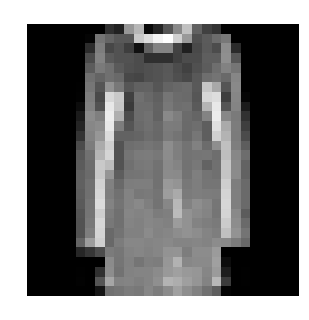

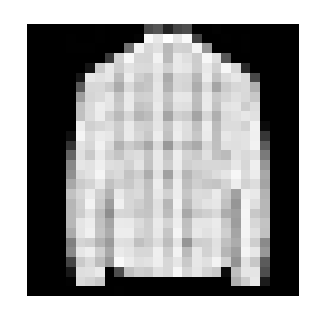

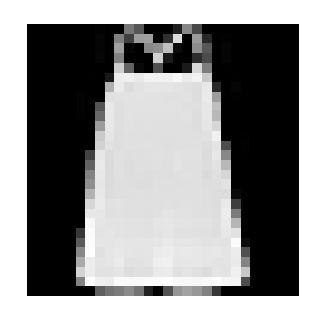

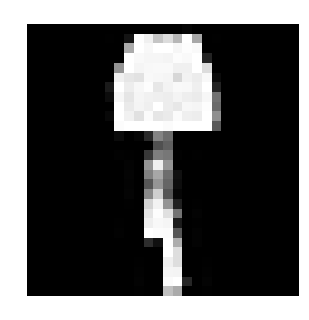

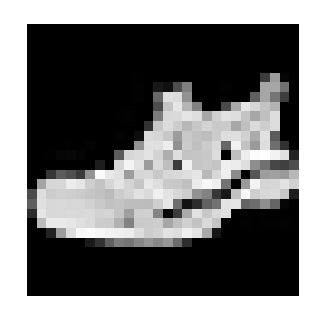

In [57]:
descs = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
wrong_preds_sample = random.sample(wrong_preds, k=5)
for image, label, pred in wrong_preds_sample:
    img = rehydrate(image.view(28, 28))
    actual = descs[label]
    predicted = descs[pred]
    title = f'Actual: {actual}, Predicted {predicted}'
    show_imgs([img], [title])

In [58]:
images, labels = next(iter(testloader))
batch_size = images.size()[0]
tot_test_size += batch_size
images.resize_(batch_size, 784)
logits = model.forward(images)
probs = F.softmax(logits, dim=1)
preds = torch.argmax(probs, dim=1)

In [59]:
print(logits.size())
print(probs.size())
print(preds.size())

torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64])


In [63]:
tp = probs.max(dim=1)
print(len(tp))

2
